In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pystan
from sklearn import preprocessing
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [82]:
def preprocess(df):
    #参加数でフィルタ
    df=df[df["attendnum"]>=20]
    
    #未提出者の除外
    df=df[df.iloc[:,2:].sum(axis=1)>0]
    del df["attendnum"]
    
    #１０(不正解)を0に変換
    df.iloc[:,1:]=df.iloc[:,1:].where(df.iloc[:,1:]!=10,0)
    return df

In [100]:
def makecontestfeat(df):
    columns=df.columns[1:]
    ret=np.zeros((len(columns),2))
    probnames=[]
    for num,i in enumerate(columns):
        probnames.append(i)
        ret[num,0]=df[df[i]==1]["OldRating"].mean()
        ret[num,1]=df[i].mean()
    ret=pd.DataFrame(ret)
    ret.columns=["mean_rating","mean_solve_rate"]
    ret["probname"]=probnames
    return ret

In [101]:
def makebasedf(df):
    columns=df.columns[1:]
    ret=np.zeros((len(columns),2))
    maindf=pd.DataFrame()
    probname=[]
    for num,i in enumerate(columns):
        tmpdf=df[["OldRating",i]]
        tmpdf["probname"]=i
        tmpdf.rename(columns={i:"target"},inplace=True)
        maindf=pd.concat([maindf,tmpdf],axis=0)
    return maindf

In [102]:
df1=preprocess(pd.read_csv("preprocessed_nikkei.csv"))
df2=preprocess(pd.read_csv("preprocessed_agc29.csv"))
df3=preprocess(pd.read_csv("preprocessed_minna.csv"))

In [103]:
df=pd.DataFrame()
for i in [df1,df2,df3]:
    maindf=makebasedf(i)
    contestfeat=makecontestfeat(i)
    maindf=pd.merge(maindf,contestfeat,on="probname",how="left")
    df=pd.concat([df,maindf],axis=0)

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [141]:
df.head(5)

,OldRating,target,probname,mean_rating,mean_solve_rate
0,2989,1,nikkei2019_qual_a,1464.930921,0.988082
1,3649,1,nikkei2019_qual_a,1464.930921,0.988082
2,3390,1,nikkei2019_qual_a,1464.930921,0.988082
3,2806,1,nikkei2019_qual_a,1464.930921,0.988082
4,2589,1,nikkei2019_qual_a,1464.930921,0.988082


In [114]:
X=df.drop(["probname","target"],axis=1)
y=df["target"]

In [112]:
y.value_counts()

0    8970
1    7500
Name: target, dtype: int64

In [121]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
params={
    'random_state' : 1,
    'objective': 'binary',
    #'metric': 'auc',
    'metric': 'binary_error',
    }

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

bst = lgb.train(params, dtrain, num_boost_round=1000,valid_sets=[dtrain,dvalid],early_stopping_rounds=50,verbose_eval=10)

#d_test = pred_df
#p_test+=bst.predict(d_test)
#p_test+=bst.predict(test2)
#score+=bst.best_score["valid_0"]['multi_error']

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_error: 0.0736187	valid_1's binary_error: 0.068306
[20]	training's binary_error: 0.0730115	valid_1's binary_error: 0.0670917
[30]	training's binary_error: 0.0724803	valid_1's binary_error: 0.0655738
[40]	training's binary_error: 0.0721008	valid_1's binary_error: 0.0664845
[50]	training's binary_error: 0.0714936	valid_1's binary_error: 0.0661809
[60]	training's binary_error: 0.07119	valid_1's binary_error: 0.0658774
[70]	training's binary_error: 0.0704311	valid_1's binary_error: 0.0655738
[80]	training's binary_error: 0.0701275	valid_1's binary_error: 0.0661809
Early stopping, best iteration is:
[35]	training's binary_error: 0.0721767	valid_1's binary_error: 0.0649666


In [131]:
#予測セットの作成
probsets=df[["probname","mean_rating","mean_solve_rate"]].drop_duplicates()
rating=[i*10 for i in range(300)]
result=pd.DataFrame()
for index, row in probsets.iterrows():
    tmp=pd.DataFrame()
    tmp["rating"]=rating
    tmp["mean_rating"]=row["mean_rating"]
    tmp["mean_solve_rate"]=row["mean_solve_rate"]
    tmp["pred"]=bst.predict(tmp)
    tmp["name"]=row["probname"]
    #print(tmp)
    result=pd.concat([result,tmp],axis=0)

In [132]:
result

,rating,mean_rating,mean_solve_rate,pred,name
0,0,1464.930921,0.988082,0.671478,nikkei2019_qual_a
1,10,1464.930921,0.988082,0.671478,nikkei2019_qual_a
2,20,1464.930921,0.988082,0.671478,nikkei2019_qual_a
3,30,1464.930921,0.988082,0.671478,nikkei2019_qual_a
4,40,1464.930921,0.988082,0.671478,nikkei2019_qual_a
5,50,1464.930921,0.988082,0.671478,nikkei2019_qual_a
6,60,1464.930921,0.988082,0.671478,nikkei2019_qual_a
7,70,1464.930921,0.988082,0.671478,nikkei2019_qual_a
8,80,1464.930921,0.988082,0.671478,nikkei2019_qual_a
9,90,1464.930921,0.988082,0.671478,nikkei2019_qual_a


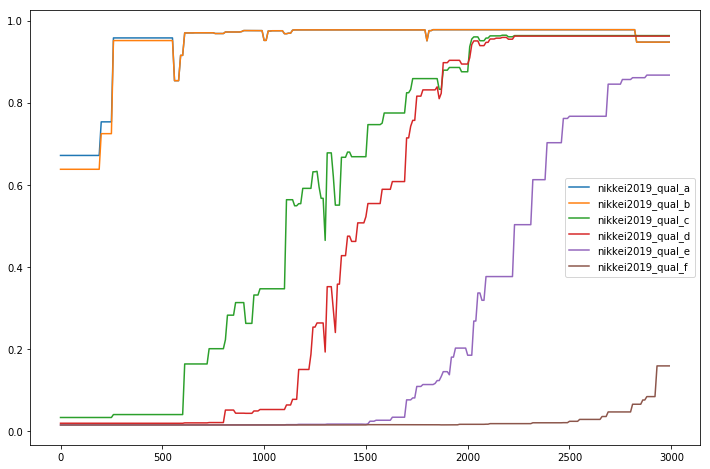

In [136]:
plt.figure(figsize=(12,8))
for i in result["name"].unique()[:6]:
    target=result[result["name"]==i]
    plt.plot(target["rating"],target["pred"],label=i)
    plt.legend()
plt.show()

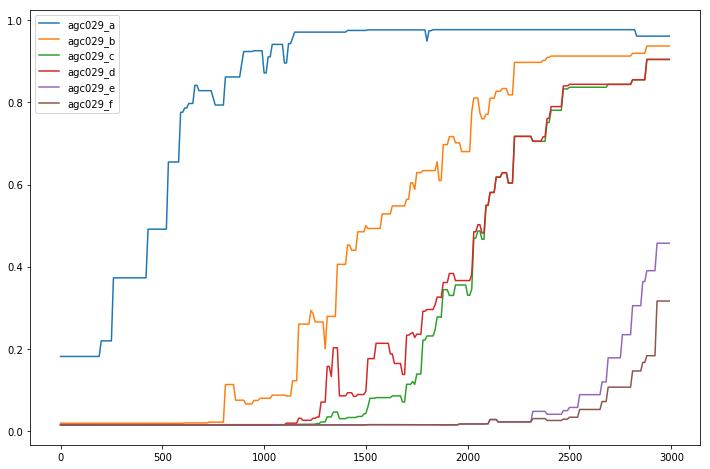

In [137]:
plt.figure(figsize=(12,8))
for i in result["name"].unique()[6:12]:
    target=result[result["name"]==i]
    plt.plot(target["rating"],target["pred"],label=i)
    plt.legend()
plt.show()

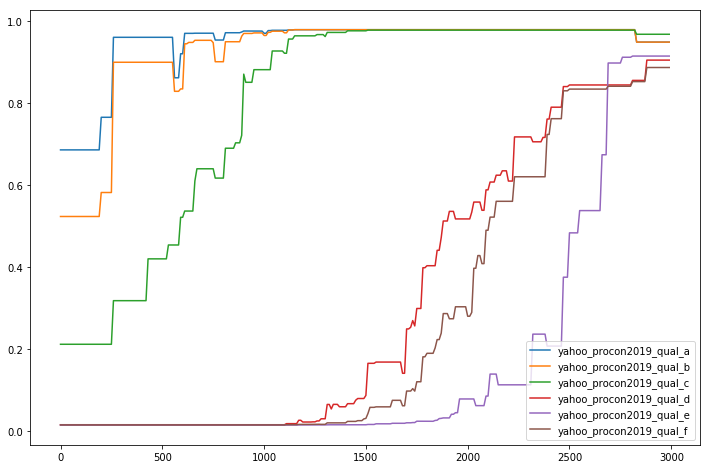

In [138]:
plt.figure(figsize=(12,8))
for i in result["name"].unique()[12:18]:
    target=result[result["name"]==i]
    plt.plot(target["rating"],target["pred"],label=i)
    plt.legend()
plt.show()